# 0. Explore hydrodynamical simulations used by cogsworth
*Part of a series of notebooks accompanying Wagg+2025*

In [39]:
import cogsworth
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd
import gala.potential as gp

In [27]:
import sys
sys.path.append("../src")
import plotting

In [28]:
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Get m11h

In [29]:
%%time
m11h = cogsworth.hydro.utils.prepare_snapshot("/mnt/home/chayward/firesims/fire2/public_release/core/m11h_res7100/output/snapshot_600.hdf5")

cogsworth warning: Looks like you're loading a snapshot that doesn't specify its units, I'm going to infer them but make sure the outputted units looks right!
cogsworth warning: I couldn't find a halo catalogue, so I'll use pynbody's built-in halo finder to centre the snapshot


CPU times: user 6.12 s, sys: 1.44 s, total: 7.57 s
Wall time: 6.32 s


## Isolate the central region

In [5]:
mask = (m11h["x"]**2 + m11h["y"]**2 + m11h["z"]**2)**(0.5) < 100

In [6]:
m11h_h1 = m11h[mask]

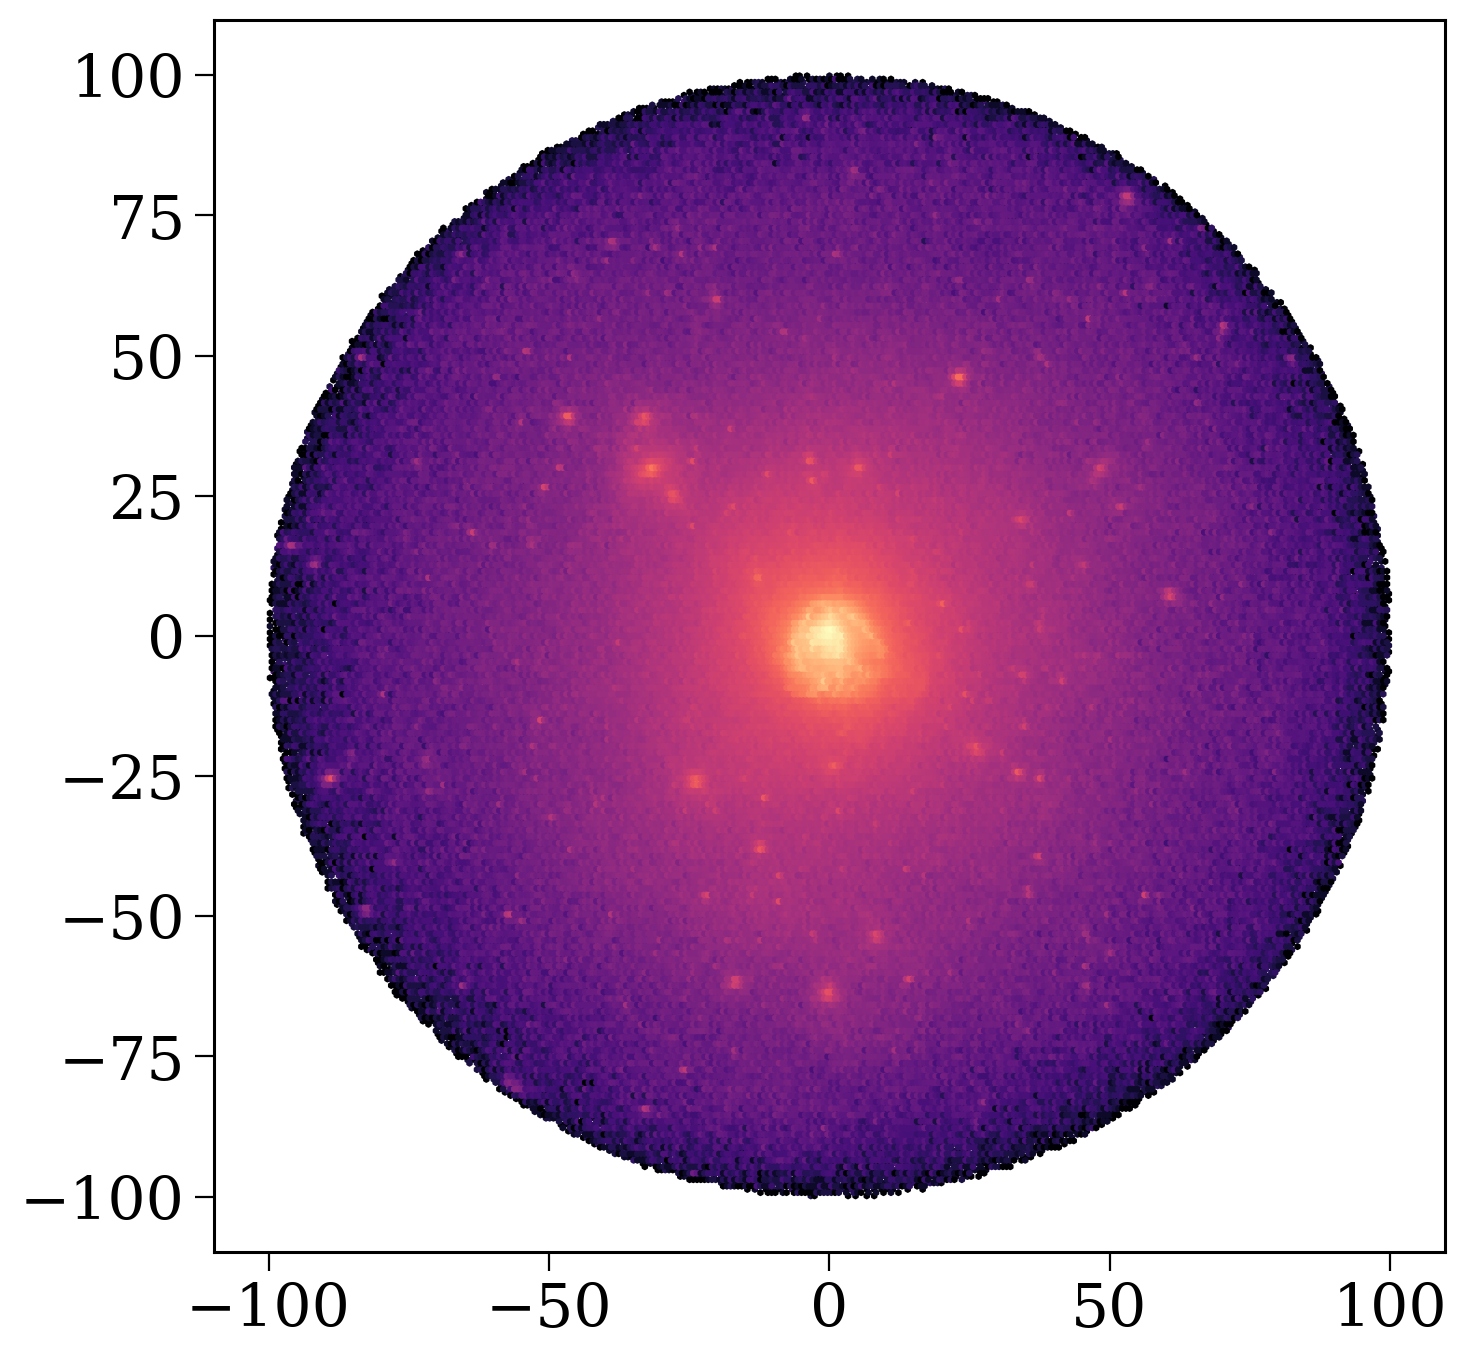

In [31]:
fig, ax = plt.subplots()
ax.hexbin(m11h_h1["x"], m11h_h1["y"], bins="log", gridsize=300, cmap="magma")
ax.set_aspect("equal")
plt.show()

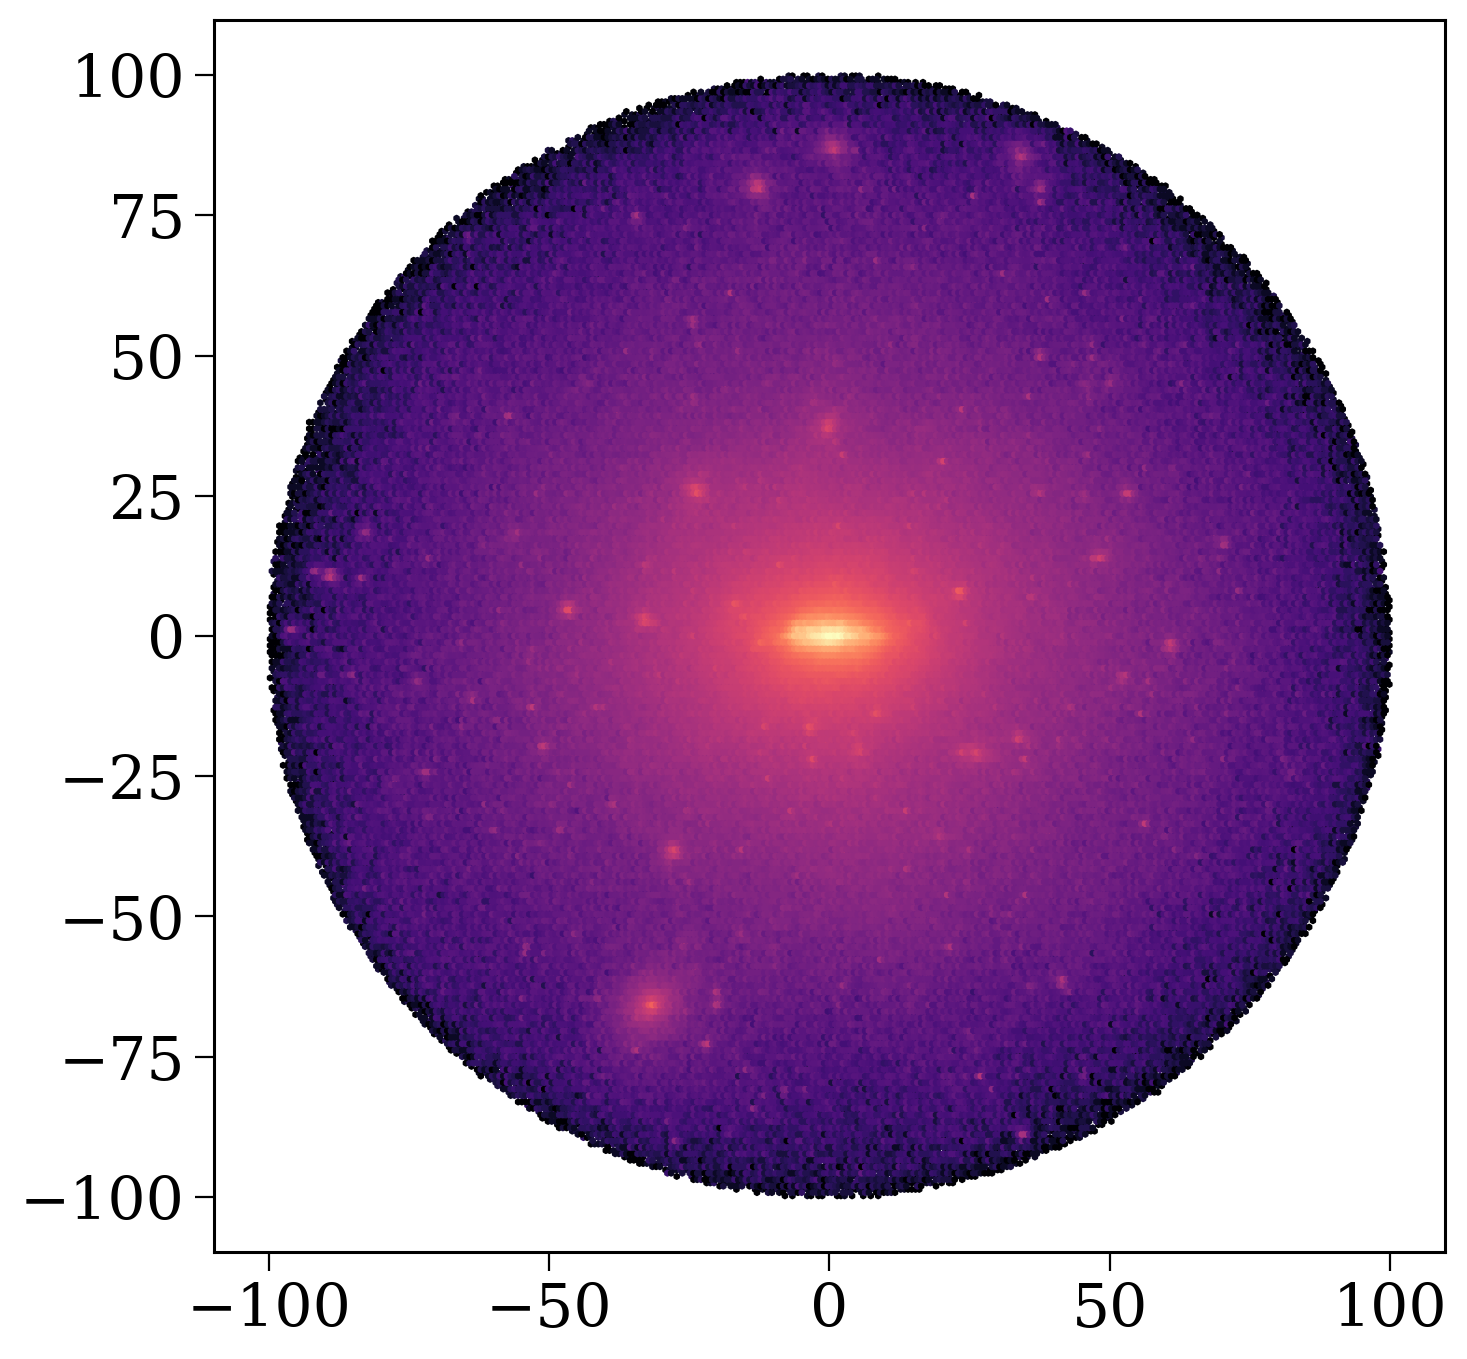

In [33]:
fig, ax = plt.subplots()
ax.hexbin(m11h_h1["x"], m11h_h1["z"], bins="log", gridsize=300, cmap="magma")
ax.set_aspect("equal")
plt.show()

# Stellar mass and star formation history

In [8]:
m11h_h1.s["mass"].sum()

SimArray(4.04838775e+09, 'Msol')

In [34]:
t_mask = (13736.52127883025 - m11h_h1.s["tform"].in_units("Myr")) < 150

In [35]:
m11h_h1.s["mass"][t_mask].sum() / 150e6

SimArray(0.48707225, 'Msol')

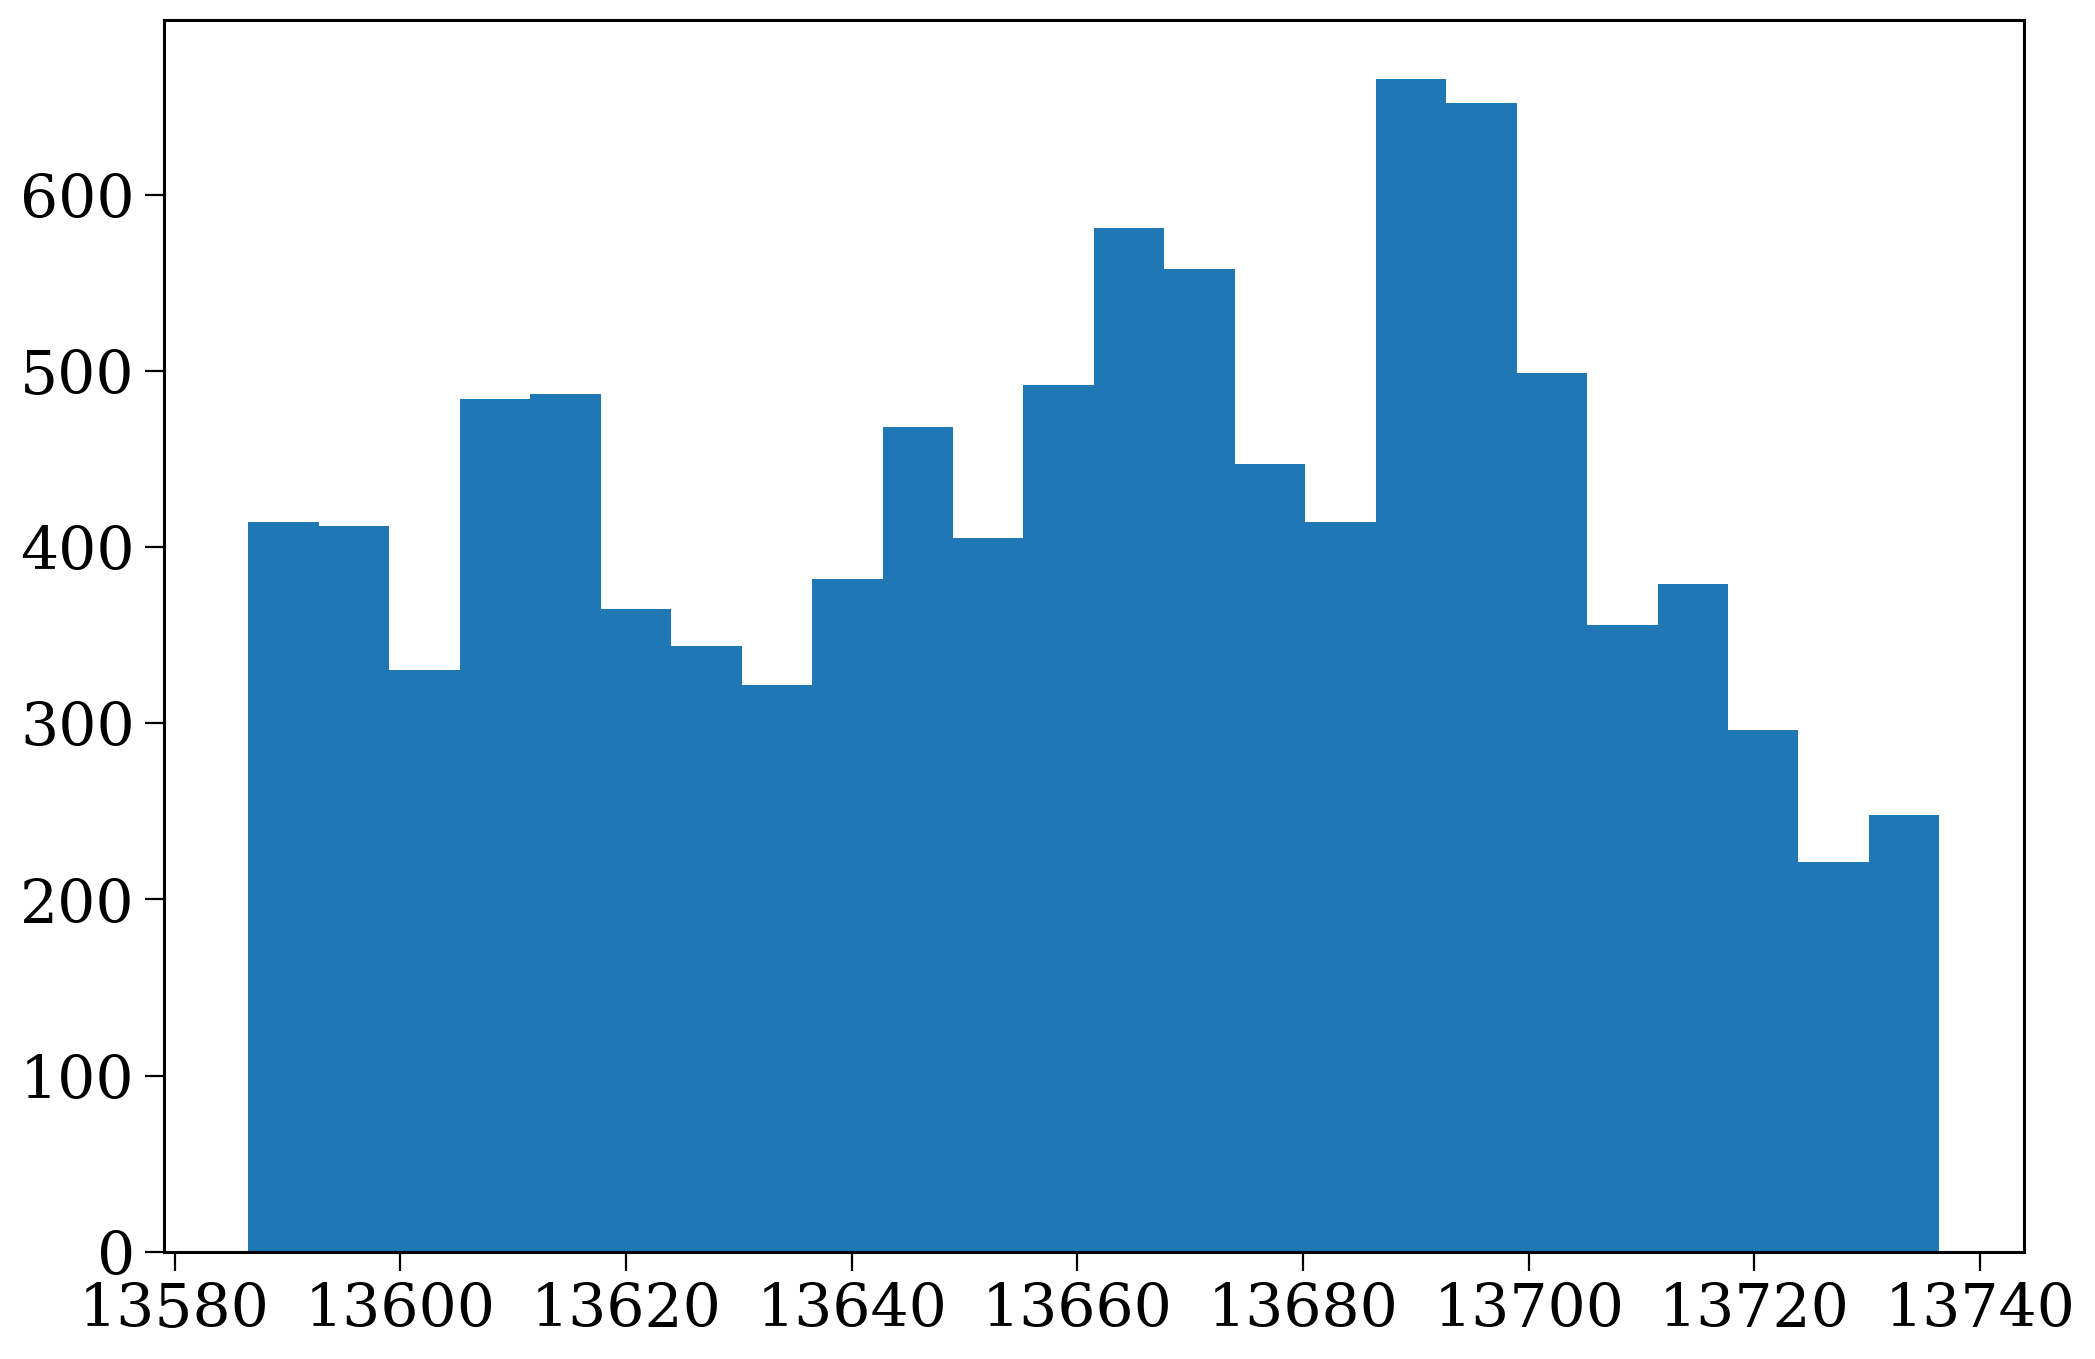

In [36]:
plt.hist(m11h_h1.s["tform"].in_units("Myr")[t_mask], bins="fd");
plt.show()

In [37]:
m11h_h1.s["tform"].in_units("Myr")[t_mask]

SimArray([13735.63842149, 13735.70540892, 13735.06816999, ...,
          13733.83406006, 13720.94105661, 13674.03446871], 'Myr')

# Disc mass

In [40]:
m11h_pot = gp.load("../data/m11h_new_potential.yml")

In [41]:
R_range = np.linspace(0.00001, 25, 1000) * u.kpc
# pot_at_R = m11h_pot(q=[R_range, np.zeros_like(R_range), np.zeros_like(R_range)])
vcirc_at_R = m11h_pot.circular_velocity(q=[R_range, np.zeros_like(R_range), np.zeros_like(R_range)])

In [42]:
R = np.sqrt(m11h_h1["x"]**2 + m11h_h1["y"]**2)

In [44]:
from scipy.interpolate import interp1d

In [45]:
vcirc_at_R_func = interp1d(R_range, vcirc_at_R)

In [46]:
mass_enclosed_at_R_func = interp1d(np.sort(R), m11h_h1["mass"][np.argsort(R)].cumsum())

In [47]:
def compute_circularity(snap, vcirc_at_R_func, mass_enclosed_at_R_func):
    """
    Compute the circularity (ε) of particles in a galaxy simulation.

    Parameters:
    positions : ndarray, shape (N, 3)
        Positions of particles in kpc.
    velocities : ndarray, shape (N, 3)
        Velocities of particles in km/s.
    masses : ndarray, shape (N,)
        Masses of particles in Msun.
    potential_function : function
        A function Φ(R) that returns the gravitational potential at a given radius R.

    Returns:
    circularity : ndarray, shape (N,)
        Circularity values for each particle.
    """
    
    # Compute cylindrical radius R
    R = np.sqrt(snap["x"]**2 + snap["y"]**2)
    
    # Compute specific angular momentum along the z-axis
    J_z = snap["x"] * snap["vy"] - snap["y"] * snap["vx"]  # Specific angular momentum in kpc * km/s

    print(J_z)

    # v_circ = vcirc_at_R_func(R)
    v_circ = np.sqrt(const.G * mass_enclosed_at_R_func(R) * u.Msun / (R * u.kpc)).to(u.km / u.s)
    
    # Compute circular angular momentum J_circ = R * v_circ
    J_circ = R * v_circ
    
    # Avoid division by zero for non-disk particles
    J_circ[J_circ == 0] = np.nan

    print(J_circ)
    
    # Compute circularity
    epsilon = J_z / J_circ
    
    return epsilon.value, R, J_z, v_circ, J_circ

In [49]:
%%time
eps = compute_circularity(m11h_h1, vcirc_at_R_func, mass_enclosed_at_R_func)[0]

[-574.06982324 -330.52463999  174.14100809 ... 2719.80019342 2765.69784395
 2062.582381  ]
[6933.37498201 6830.50544536 6769.14606786 ... 5681.99259436 5902.18523778
 4605.5219635 ] km / s
CPU times: user 2.2 s, sys: 158 ms, total: 2.36 s
Wall time: 2.36 s


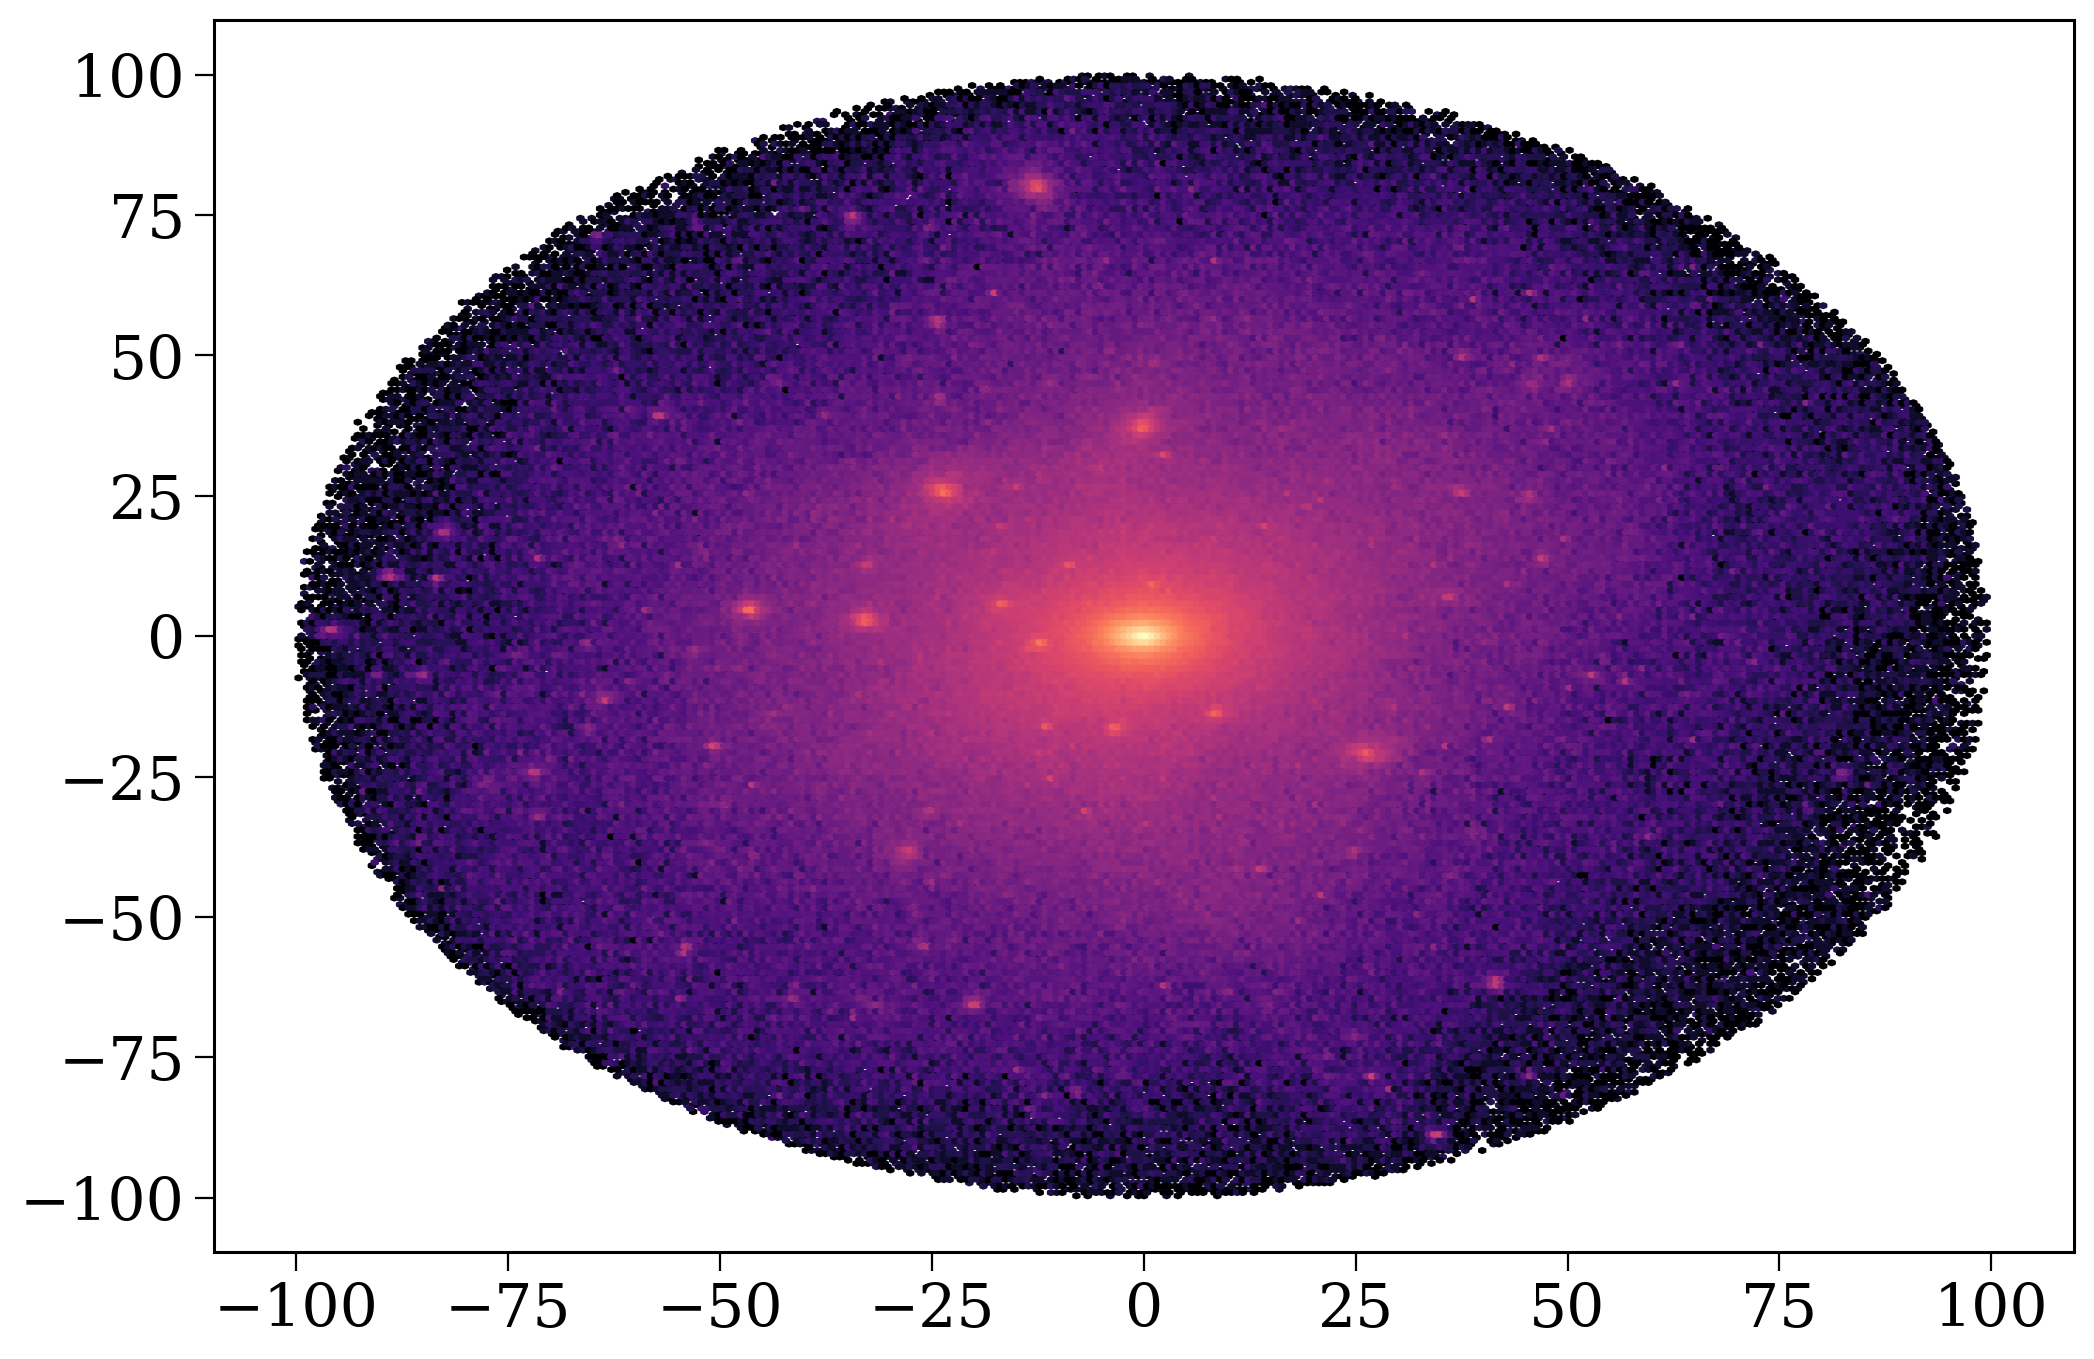

In [50]:
plt.hexbin(m11h_h1["x"][eps <= 0], m11h_h1["z"][eps <= 0], bins="log", gridsize=300, cmap="magma")

In [56]:
m11h_h1[eps <= 0]["mass"].sum()

SimArray(5.94841093e+10, 'Msol')